## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from scipy.stats import norm
from scipy import stats as st

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer 

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

Устанавливаем отображение до двух знаков после запятой

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

### Ознакомление с данными

Загружаем данные

In [3]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data['RegistrationYear'].describe()

count   354,369.00
mean      2,004.23
std          90.23
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: RegistrationYear, dtype: float64

Количество пропусков по столбцам

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Процент пропусков по столбцам

In [7]:
data.isna().mean()

DateCrawled         0.00
Price               0.00
VehicleType         0.11
RegistrationYear    0.00
Gearbox             0.06
Power               0.00
Model               0.06
Kilometer           0.00
RegistrationMonth   0.00
FuelType            0.09
Brand               0.00
NotRepaired         0.20
DateCreated         0.00
NumberOfPictures    0.00
PostalCode          0.00
LastSeen            0.00
dtype: float64

In [8]:
columns_nan = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

Посмотрим уникальные значения колонок

In [9]:
for i in data.columns:
    print(data[i].value_counts())
    print()

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-31 18:50:16    5
2016-04-02 21:54:36    5
                      ..
2016-03-26 12:45:41    1
2016-04-01 15:38:27    1
2016-03-19 10:53:10    1
2016-03-27 16:58:16    1
2016-03-25 21:48:20    1
Name: DateCrawled, Length: 271174, dtype: int64

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: RegistrationYear, Length: 151, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

0

Предполагаем, что тип кузова может зависеть от модели.  
Поэтому делаем срез по данным без пропусков в колонках: __Тип Кузова, Модель, Тип коробки передач, Вид Топлива__

In [10]:
df_vehicle = data.loc[
    (~data['VehicleType'].isna()) & 
    (~data['Model'].isna()) &
    (~data['Gearbox'].isna()) &
    (~data['FuelType'].isna())
]
df_vehicle.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
10,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26 00:00:00,0,96224,2016-04-06 10:45:34
11,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16


Группируем тип кузова по моделям.  
Получаем, что у одной модели может быть много типов кузова

In [11]:
df_vehicle_pivot =  df_vehicle.pivot_table(
    index=['Model','VehicleType'],
    values='Power',
    aggfunc='count'
)
df_vehicle_pivot

Power
Model  VehicleType       
100    convertible      1
       coupe            2
       sedan          264
       wagon           99
145    coupe            2
...                   ...
zafira other           20
       sedan           19
       small            9
       suv              5
       wagon          176

[1092 rows x 1 columns]

Типы кузова на примере модели Зафира (марка - Опель)

In [12]:
df_vehicle.loc[df_vehicle['Model'] == 'zafira', ['Model', 'VehicleType']].head()

,Model,VehicleType
349,zafira,bus
405,zafira,bus
571,zafira,bus
792,zafira,other
810,zafira,wagon


Модель Зафира имеет следующие типы кузова:
1. автобус
2. фургон
3. другой
4. седан
5. малый авто
6. внедорожник
7. купе  

Типы кузова седан, внедорожник и купе объективно не применимы к Опель Зафира, так как это автомобиль типа минивэн.  

Делаем вывод, что по модели мы не сможем восстановить пропущенные данные в колонке Тип Кузова, так как одна модель имеет несколько типов кузова.  
К тому же типы кузова в данных зачастую ошибочные, что так же может негативно сказаться на обучении модели, так как будет сложнее искать закономерности.

In [13]:
df_vehicle.loc[df_vehicle['Model'] == 'zafira','VehicleType'].value_counts()

bus      2241
wagon     176
other      20
sedan      19
small       9
suv         5
coupe       1
Name: VehicleType, dtype: int64

Заменям пропущенные значения во всем ДатаФрейме на "неизвестно", так как процент пропусков большой и расставание с ними может недообучить модель.

In [14]:
data_upd = data.fillna(value = 'unknown')
data_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Удаление лишних колонок

Колонки: __Дата скачивания анкеты, Месяц регистрации авто, Дата создания объявления, Количество фото в объявлении, Почтовый индекс и дата последней активности пользователя__ могут только запутать модель, так как напрямую не могут влиять на цену, а также увеличит время обучения модели.  
Поэтому удалим эти колонки из данных.

In [15]:
data_upd = data_upd.drop(
    ['DateCrawled', 'RegistrationMonth','DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
axis='columns')
data_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         354369 non-null object
RegistrationYear    354369 non-null int64
Gearbox             354369 non-null object
Power               354369 non-null int64
Model               354369 non-null object
Kilometer           354369 non-null int64
FuelType            354369 non-null object
Brand               354369 non-null object
NotRepaired         354369 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [16]:
data_upd_vehicle_type = data_upd.drop('VehicleType',axis='columns')

### Аномалии

1. Выделяем колонки с числовыми значениями.  
2. Пишем функцию по просмотру распределения данных в этих колонках
3. Ознакамливаемся с данными

In [17]:
columns_int = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

In [18]:
def distribution(data, columns):
    for name in columns:
        plt.figure(figsize=(15,6))
        sns.set_style('darkgrid')
        
        plt.subplot(211)
        sns.distplot(data[name])
        plt.title('Распределение '+ name)
        
        plt.subplot(212)
        sns.boxplot(data[name])

        plt.tight_layout
        plt.show()
        print(data[name].describe())

1. в колонке __Цена__ данные имееют Логнормальное распределение, чем выше цена - тем меньше таких объявлений. Теоретически цена может быть любой, например, за эксклюзивные авто
2. в колонке __Год регистрации__ есть явно ошибочные значения из будущего (превышающие текущий 2021 год)
3. в колонке __Мощность__ также много аномальных значений лошадиных сил, сильно превышающих 1000 л.с.
4. в колонке __Пробег__ все значения допустимы

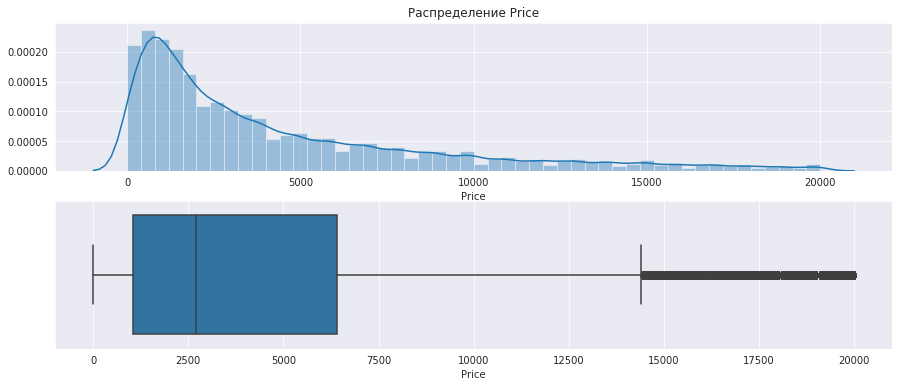

count   354,369.00
mean      4,416.66
std       4,514.16
min           0.00
25%       1,050.00
50%       2,700.00
75%       6,400.00
max      20,000.00
Name: Price, dtype: float64


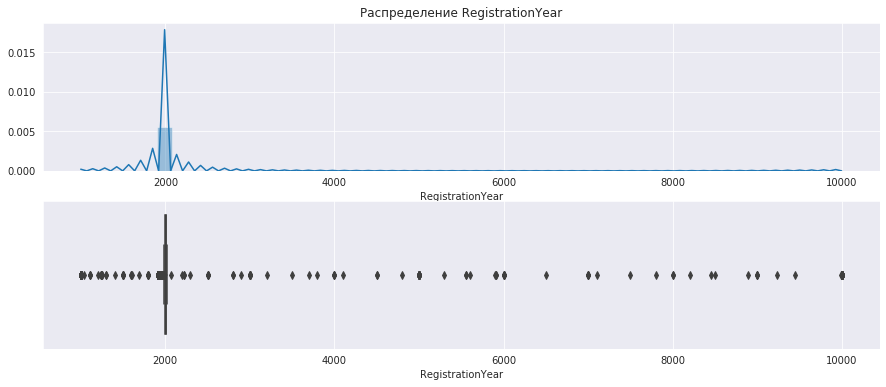

count   354,369.00
mean      2,004.23
std          90.23
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: RegistrationYear, dtype: float64


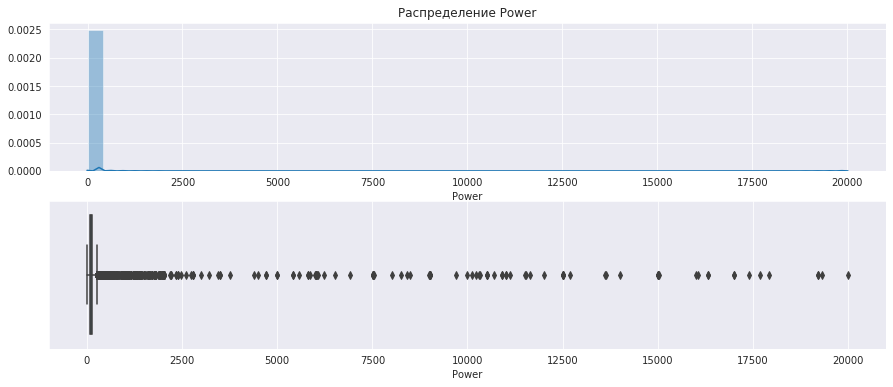

count   354,369.00
mean        110.09
std         189.85
min           0.00
25%          69.00
50%         105.00
75%         143.00
max      20,000.00
Name: Power, dtype: float64


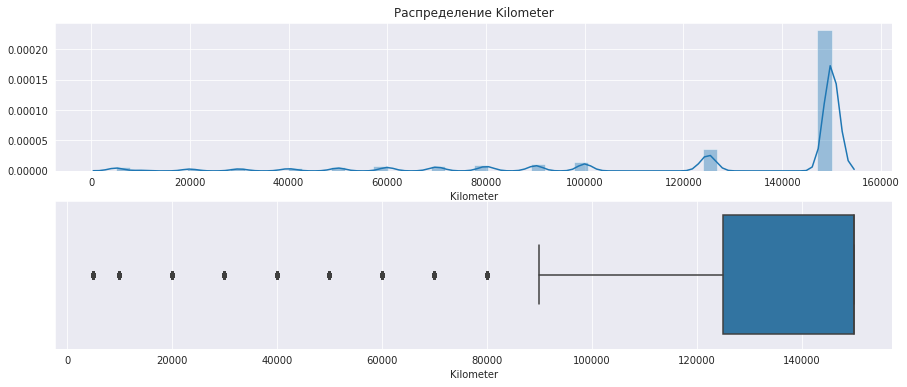

count   354,369.00
mean    128,211.17
std      37,905.34
min       5,000.00
25%     125,000.00
50%     150,000.00
75%     150,000.00
max     150,000.00
Name: Kilometer, dtype: float64


In [19]:
distribution(data_upd, columns_int)

Посмотрим на распределение колонки __Год регистрации__ с 1970 по 2020 год  
Значения раньше 1986 года крайне редкие (выбросы), модель может подстроиться под эти значения, что негативно скажется на общем алгоритме предсказаний

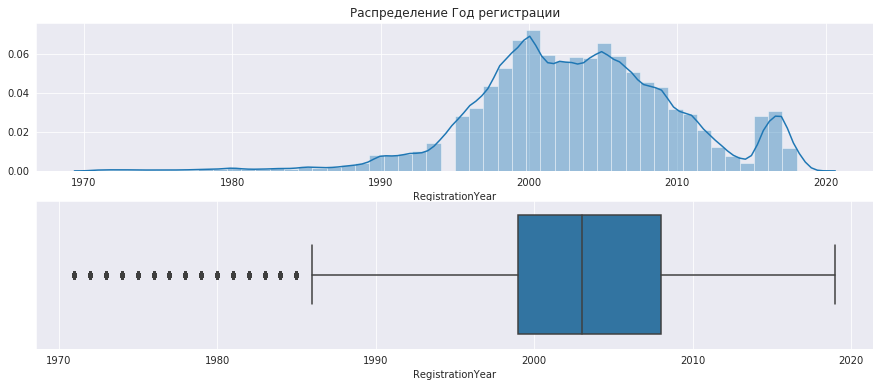

In [20]:
plt.figure(figsize=(15,6))

plt.subplot(211)
sns.distplot(data_upd.loc[
    (data_upd['RegistrationYear'] < 2021) & 
    (data_upd['RegistrationYear'] > 1970), 'RegistrationYear'
])
plt.title('Распределение Год регистрации')
        
plt.subplot(212)
sns.boxplot(data_upd.loc[
    (data_upd['RegistrationYear'] < 2021) & 
    (data_upd['RegistrationYear'] > 1970), 'RegistrationYear'
])

plt.show()

Здесь явно опечатки в дате регистрации авто

In [21]:
data_upd.loc[
    data_upd['RegistrationYear'] < 1900]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
622,0,unknown,1111,unknown,0,unknown,5000,unknown,opel,unknown
16062,190,unknown,1000,unknown,0,mondeo,5000,unknown,ford,unknown
18224,7999,unknown,1500,manual,224,impreza,5000,unknown,subaru,unknown
34332,450,unknown,1800,unknown,1800,unknown,5000,unknown,mitsubishi,no
38875,1234,unknown,1234,unknown,26,unknown,5000,unknown,trabant,unknown
...,...,...,...,...,...,...,...,...,...,...
323443,30,unknown,1000,unknown,0,unknown,5000,unknown,audi,unknown
325739,400,unknown,1000,unknown,0,unknown,5000,unknown,mercedes_benz,unknown
340759,700,unknown,1600,manual,1600,a3,150000,petrol,audi,no
348830,1,unknown,1000,unknown,1000,unknown,150000,unknown,sonstige_autos,unknown


Данные в марках авто также зачастую неактуальные, так как концерны основаны позже года регистрации, указанного в данных:  
[Mercedes-Benz](https://ru.wikipedia.org/wiki/Mercedes-Benz) с 1926 года  
[BMW](https://ru.wikipedia.org/wiki/BMW) с 1916 год  
[Volkswagen](https://ru.wikipedia.org/wiki/Volkswagen) с 1937 года  
[Ford](https://ru.wikipedia.org/wiki/Ford) с 1903 года

In [22]:
data_upd.loc[
    data_upd['RegistrationYear'] < 1900, 'Brand'].value_counts()

sonstige_autos    14
volkswagen        14
mercedes_benz      6
opel               5
trabant            4
bmw                3
mitsubishi         2
ford               2
citroen            2
audi               2
fiat               2
alfa_romeo         2
chrysler           1
land_rover         1
renault            1
rover              1
peugeot            1
skoda              1
subaru             1
porsche            1
Name: Brand, dtype: int64

Удаляем значения из колонки __Год регистрации__ позднее 2016 года (самая поздняя дата объявлений) и ранее 1900 года

In [23]:
len(data_upd.loc[(data_upd['RegistrationYear'] > 2016) | (data_upd['RegistrationYear'] < 1900)])

14596

In [24]:
data_upd = data_upd.drop(
    data_upd.loc[
        (data_upd['RegistrationYear'] > 2016) | 
        (data_upd['RegistrationYear'] < 1900)
    ].index
).reset_index(drop=True)

Посмотрим на распределение колонки __Мощность__ менее 1000 л.с.  
Свыше 251 л.с. значения уже крайне редко встречаются, однако такие характеристики авто вполне реальны

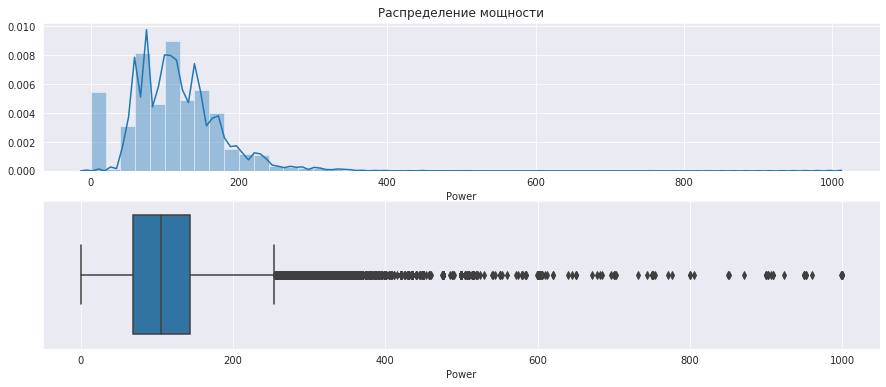

In [25]:
plt.figure(figsize=(15,6))

plt.subplot(211)
sns.distplot(data_upd.loc[
    (data_upd['Power'] < 1000), 'Power'
])
plt.title('Распределение мощности')
        
plt.subplot(212)
sns.boxplot(data_upd.loc[
    (data_upd['Power'] < 1000), 'Power'
])

plt.show()

[Мощность 1001 л.с.](https://ru.wikipedia.org/wiki/Bugatti_Veyron)
Так как самый быстрый серийный автомобиль в мире имеет мощность двигателя 1001 л.с., а также при взгляде на автомобили с мощностью более 1000 л.с. выявляем объективное несоответствие, например, toyota corolla, opel vectra, audi a6 и тд не имеют в характеристиках такой мощности.

In [26]:
data_upd.loc[
    (data_upd['Power'] > 1000)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1735,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2012,0,sedan,1999,unknown,1799,vectra,150000,petrol,opel,yes
5080,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
7310,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,unknown
7364,1500,small,2000,manual,1400,unknown,150000,petrol,honda,unknown
...,...,...,...,...,...,...,...,...,...,...
334288,1000,wagon,1996,manual,2598,a6,150000,unknown,audi,unknown
334494,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,unknown
334574,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
337435,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no


Смущают значения лошадиных сил равных нулю. Видимо, пользователи просто не указали их при заполнении анкеты

In [27]:
data_upd.loc[
    (data_upd['Power'] == 0)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
30,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
35,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
38,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
339742,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
339750,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
339767,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
339768,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Удаляем значения в колонке __Мощность__ выше 1000 л.с., так как это единичные данные, которые ошибочны

In [28]:
len(data_upd.loc[data_upd['Power'] > 1000])

277

In [29]:
data_upd = data_upd.drop(
    data_upd.loc[data_upd['Power'] > 1000].index
).reset_index(drop=True)

In [30]:
data_upd['RegistrationYear'].describe()

count   339,496.00
mean      2,002.48
std           7.09
min       1,910.00
25%       1,999.00
50%       2,003.00
75%       2,007.00
max       2,016.00
Name: RegistrationYear, dtype: float64

Сгруппируем авто по возрасту на основании квартилей

In [31]:
def year_status(year):
    if year <= 1999:
        return 'очень старый'
    elif 1999 < year <= 2003:
        return 'старый'
    elif  2003< year <= 2007:
        return 'средний'
    else:
        return 'почти новый'

In [32]:
data_upd['year_status'] = data_upd['RegistrationYear'].apply(year_status)
data_upd.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,year_status
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown,очень старый


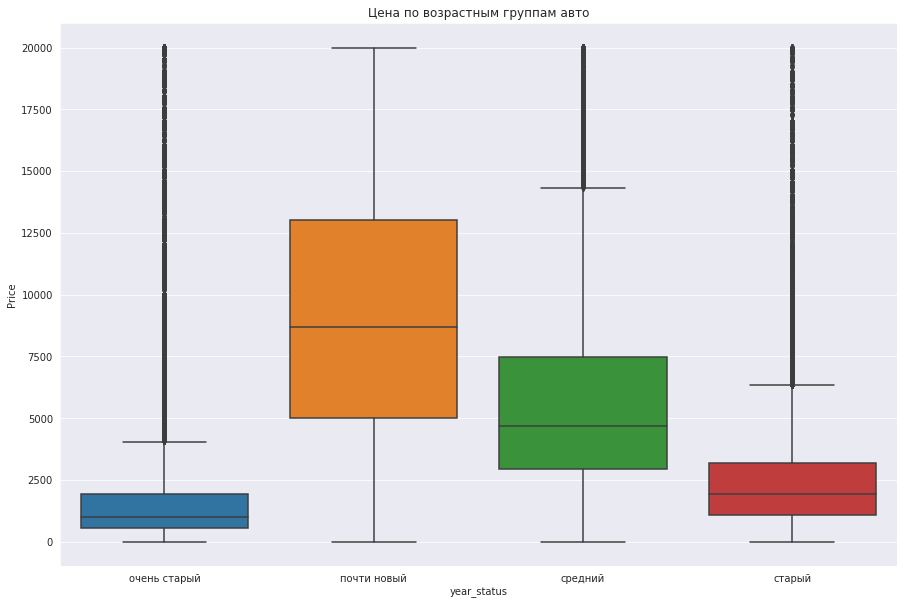

In [33]:
plt.figure(figsize=(15,10))
figure = sns.boxplot(
    x=data_upd['year_status'],
    y=data_upd['Price'],
    data=pd.melt(data_upd)
)
plt.title('Цена по возрастным группам авто')

plt.show()

In [34]:
mean_price = data_upd.groupby('year_status')['Price'].mean()
mean_price

year_status
очень старый   1,816.11
почти новый    9,049.80
средний        5,587.19
старый         2,539.88
Name: Price, dtype: float64

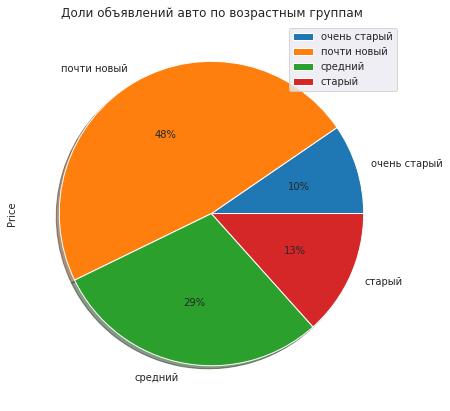

In [35]:
fig = plt.figure(figsize=(7,7))
mean_price.plot(
    kind='pie',
    y=mean_price,
    title='Доли объявлений авто по возрастным группам',
    legend=True,
    autopct='%1.0f%%',
    shadow=True
)

plt.show()

Практически половину выборки заняли новые авто

Нулевая гипотеза утверждает о равенстве средней цены обеих возрастных групп авто, тогда альтернативная гипотеза будет свидетельствовать об обратном.

Н0: средняя цена Старых авто = средняя цена Новых авто

Н1: ср. цены двух групп отличаются

Р-уровень значимости = 0.05

Для проверки гипотезы укрупним группы:  
- очень старый + старый = Старые авто
- средний + почти новый = Новые авто

In [36]:
old = data_upd.loc[
    (data_upd['year_status'] == 'очень старый') |
    (data_upd['year_status'] == 'старый'), 'Price'
     ]
new = data_upd.loc[
    (data_upd['year_status'] == 'средний') |
    (data_upd['year_status'] == 'почти новый'), 'Price'
     ]

In [37]:
variance_old = np.var(old, ddof=1)
print('Дисперсия цены старых и очень старых авто: {:,.2f}'.format(variance_old))

Дисперсия цены старых и очень старых авто: 6,162,783.92


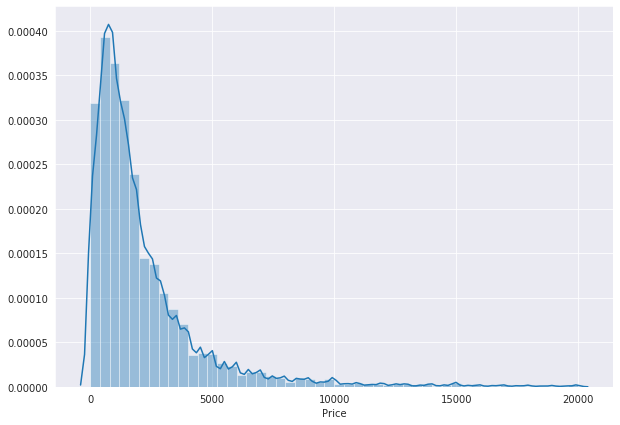

In [38]:
plt.figure(figsize=(10,7))
sns.distplot(old)

plt.show()

In [39]:
old.describe()

count   185,475.00
mean      2,141.52
std       2,482.50
min           0.00
25%         700.00
50%       1,400.00
75%       2,600.00
max      20,000.00
Name: Price, dtype: float64

In [40]:
variance_new = np.var(new, ddof=1)
print('Дисперсия цены средних и почти новых авто: {:,.2f}'.format(variance_new))

Дисперсия цены средних и почти новых авто: 23,722,046.56


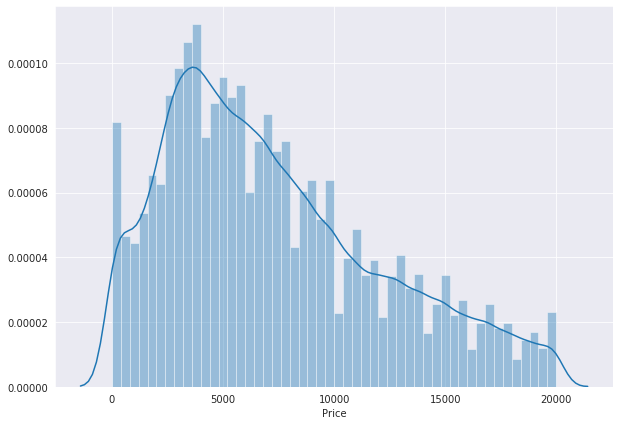

In [41]:
plt.figure(figsize=(10,7))
sns.distplot(new)

plt.show()

In [42]:
new.describe()

count   154,021.00
mean      7,279.55
std       4,870.53
min           0.00
25%       3,500.00
50%       6,299.00
75%      10,250.00
max      20,000.00
Name: Price, dtype: float64

Так как дисперсия силльно разница equal_var=False

In [43]:
alpha = 0.05
result = st.ttest_ind(old, new, equal_var=False)
print(f'p-значение: {result.pvalue}')
if result.pvalue < alpha:
    print(f"Отвергаем Н0")
else:
    print(f'Не получилось отвергнуть Н0')

p-значение: 0.0
Отвергаем Н0


Для проверки гипотезы о равенстве средних значений двух выборок изпользовали тест Стьюдента. Отвергаем нулевую гипотезу, так как p-значение, полученное в тесте, много меньше уровня значимости, установленного в 5%.

Удалим колонку с возрастными группами, чтобы не мешалась при формировании выборок для моделирования

In [44]:
data_upd = data_upd.drop('year_status', axis='columns')

Проверяем отсутствие пропусков

In [45]:
data_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339496 entries, 0 to 339495
Data columns (total 10 columns):
Price               339496 non-null int64
VehicleType         339496 non-null object
RegistrationYear    339496 non-null int64
Gearbox             339496 non-null object
Power               339496 non-null int64
Model               339496 non-null object
Kilometer           339496 non-null int64
FuelType            339496 non-null object
Brand               339496 non-null object
NotRepaired         339496 non-null object
dtypes: int64(4), object(6)
memory usage: 25.9+ MB


In [46]:
data_upd.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Дубликаты

Найденные дубликаты, на самом деле не дубликаты

In [47]:
data_upd.duplicated().sum()

44093

In [48]:
data_upd.loc[data_upd.duplicated()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1063,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
1329,0,unknown,2000,unknown,0,unknown,150000,unknown,volvo,unknown
2073,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no
2707,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
2892,2800,wagon,2005,unknown,0,touran,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
339479,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no
339482,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no
339485,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
339486,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


### Корреляция

Проверим корреляцию между числовыми данными

In [49]:
data_upd[columns_int].corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.00,0.43,0.48,-0.34
RegistrationYear,0.43,1.00,0.16,-0.20
Power,0.48,0.16,1.00,0.09
Kilometer,-0.34,-0.20,0.09,1.00


Значительных взаимосвязей не выявлено, которые могли бы негативно повлиять на обучение модели

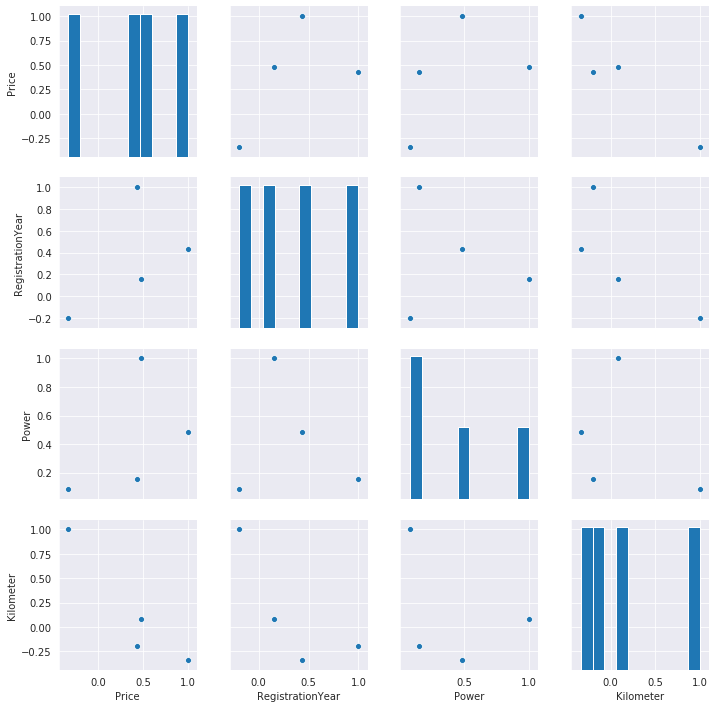

In [50]:
sns.pairplot(data_upd[columns_int].corr())
plt.show()

### Вывод:
1. пропущенные значения заменили на вставку "unknown", так как пропуски составили значительный процент от общего массива данных
2. удалили столбцы, не влияющие на целевой признак - цену авто
3. выявили аномалии в столбце __Мощность__ и нереальные значения в столбце __Год регистрации авто__
4. сильной взаимосвязи между значениями признаков не выявлено

## Обучение моделей

### Формирование выборок

Выделяем признаки для обучения и целевой признак

In [51]:
features = data_upd.drop('Price', axis='columns')
target = data_upd['Price']

In [52]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345)

In [53]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

In [54]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(203697, 9)
(67899, 9)
(67900, 9)


In [55]:
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(203697,)
(67899,)
(67900,)


Кодируем категориальные признаки методом Ordinal Encoding в числовые и формируем выборки

In [56]:
categorical=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

In [57]:
data_ordinal = data_upd.copy(deep=True)
data_ordinal.tail(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
339495,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,unknown


In [58]:
data_upd.tail(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
339495,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,unknown


In [59]:
encoder = OrdinalEncoder()
encoder.fit(data_ordinal[categorical])
data_ordinal[categorical] = encoder.transform(data_ordinal[categorical])
data_ordinal.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,7.00,1993,1.00,0,116.00,150000,6.00,38.00,1.00
1,18300,2.00,2011,1.00,190,228.00,125000,2.00,1.00,2.00
2,9800,6.00,2004,0.00,163,117.00,125000,2.00,14.00,1.00


In [60]:
features_ordinal = data_ordinal.drop('Price', axis='columns')
target_ordinal = data_ordinal['Price']

In [61]:
features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal = train_test_split(
    features_ordinal, target_ordinal, test_size=0.4, random_state=12345)

In [62]:
features_valid_ordinal, features_test_ordinal, target_valid_ordinal, target_test_ordinal = train_test_split(
    features_valid_ordinal, target_valid_ordinal, test_size=0.5, random_state=12345)

In [63]:
print(features_train_ordinal.shape)
print(features_valid_ordinal.shape)
print(features_test_ordinal.shape)

(203697, 9)
(67899, 9)
(67900, 9)


In [64]:
print(target_train_ordinal.shape)
print(target_valid_ordinal.shape)
print(target_test_ordinal.shape)

(203697,)
(67899,)
(67900,)


Кодируем категориальные признаки методом One Hot Encoding в числовые и формируем выборки

In [65]:
data_ohe = pd.get_dummies(data_upd, drop_first=True)
data_ohe.head(3)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [66]:
features_ohe = data_ohe.drop('Price', axis='columns')
target_ohe = data_ohe['Price']

In [67]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.4, random_state=12345)

In [68]:
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
    features_valid_ohe, target_valid_ohe, test_size=0.5, random_state=12345)

In [69]:
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(203697, 311)
(67899, 311)
(67900, 311)


In [70]:
print(target_train_ohe.shape)
print(target_valid_ohe.shape)
print(target_test_ohe.shape)

(203697,)
(67899,)
(67900,)


__Обучение моделей__

### Случайный лес

In [71]:
model = RandomForestRegressor(n_estimators=5, random_state=12345)
model.fit(features_train_ohe, target_train_ohe)
prediction_valid = model.predict(features_valid_ohe)
rmse = np.sqrt(mean_squared_error(target_valid_ohe, prediction_valid))

print('Модель Случайный лес: RMSE = {:.2f}'.format(rmse))

Модель Случайный лес: RMSE = 1820.84


Проверяем с теми же параметрами, но кросс-валидацией.  
Результат даже хуже

In [72]:
model = RandomForestRegressor(n_estimators=5, random_state=12345)

score_val = cross_val_score(
    model,
    features_train_ohe,
    target_train_ohe,
    scoring='neg_mean_squared_error',
    cv=5)

score = pd.Series(score_val).mean()

rmse = np.sqrt(score* (-1))


print('Модель Случайный лес (cross_val): RMSE = {:.2f}'.format(rmse))

Модель Случайный лес (cross_val): RMSE = 1858.88


Перебираем гиперпараметр количество деревьев от 10 до 20.  
Наилучший результат при 20 деревьях

In [73]:
best_est = 0
best_score_forest = 5000
best_model_forest = None

for est in range(10, 21, 10):
    model = RandomForestRegressor(
        random_state=12345,
        n_estimators = est
    )
        
    model.fit(features_train_ohe, target_train_ohe)
    prediction_valid = model.predict(features_valid_ohe)
        
    score = np.sqrt(mean_squared_error(target_valid_ohe, prediction_valid))
        
    if score < best_score_forest:
        best_score_forest = score
        best_est = est
        best_model_forest = model
                

print('Случайный лес: RMSE = {:.2f}'.format(best_score_forest))
print(f'кол-во деревьев: {best_est}')

Случайный лес: RMSE = 1750.82
кол-во деревьев: 20


### Линейная регрессия

In [74]:
model_LNR = LinearRegression()
model_LNR.fit(features_train_ohe, target_train_ohe)
prediction_valid = model_LNR.predict(features_valid_ohe)
score_LNR = np.sqrt(mean_squared_error(target_valid_ohe, prediction_valid))

print('Модель Линейная регрессия: RMSE = {:.2f}'.format(score_LNR))

Модель Линейная регрессия: RMSE = 2769.52


### CatBoostRegressor

Проверяем метрику на модели CatBoostRegressor, при 10 итерациях

In [75]:
model = CatBoostRegressor(loss_function="RMSE", iterations=10, verbose=10)

categorical=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

model.fit(features_train, target_train, cat_features=categorical)
prediction_valid = model.predict(features_valid)
rmse = np.sqrt(mean_squared_error(target_valid, prediction_valid))

print('Модель CatBoostRegressor: RMSE = {:.2f}'.format(rmse))

0:	learn: 4464.1083833	total: 348ms	remaining: 3.13s
9:	learn: 3818.0834307	total: 2.34s	remaining: 0us
Модель CatBoostRegressor: RMSE = 3789.36


Перебираем гиперпараметры: кол-во итераций от 100 до 200 с шагом 50, глубина дерева от 6 до 10 с шагом 2.  
Наилучший результат при 200 деревьях с глубиной дерева 10

In [76]:
best_iterations = 0
best_depth = 0
best_score_CBR = 5000
best_model_CDR = None

for iteration in range(100, 210, 50):
    for depth in range(6, 11, 2):
        model = CatBoostRegressor(
            loss_function="RMSE",
            iterations = iteration,
            depth = depth,
            verbose=100
        )
        
        model.fit(features_train, target_train, cat_features=categorical)
        prediction_valid = model.predict(features_valid)

        score = np.sqrt(mean_squared_error(target_valid, prediction_valid))

        if score < best_score_CBR:
            best_score_CBR = score
            best_iterations = iteration
            best_depth = depth
            best_model_CDR = model
                

print('CatBoostRegressor: RMSE = {:.2f}'.format(best_score_CBR))
print(f'кол-во итераций: {best_iterations}')
print(f'глубина: {best_depth}')

0:	learn: 4464.1083833	total: 149ms	remaining: 14.7s
99:	learn: 2108.8057130	total: 20.7s	remaining: 0us
0:	learn: 4459.5908630	total: 225ms	remaining: 22.3s
99:	learn: 2015.8155074	total: 27.7s	remaining: 0us
0:	learn: 4455.7438010	total: 245ms	remaining: 24.3s
99:	learn: 1944.8773785	total: 30.7s	remaining: 0us
0:	learn: 4464.1083833	total: 123ms	remaining: 18.3s
100:	learn: 2105.4438358	total: 20.8s	remaining: 10.1s
149:	learn: 2006.2929172	total: 30.8s	remaining: 0us
0:	learn: 4459.5908630	total: 215ms	remaining: 32.1s
100:	learn: 2012.8165363	total: 27.3s	remaining: 13.2s
149:	learn: 1921.8485379	total: 40.5s	remaining: 0us
0:	learn: 4455.7438010	total: 259ms	remaining: 38.6s
100:	learn: 1941.9144026	total: 31.5s	remaining: 15.3s
149:	learn: 1853.1683810	total: 46.6s	remaining: 0us
0:	learn: 4463.0405921	total: 480ms	remaining: 1m 35s
100:	learn: 2083.5212736	total: 44.4s	remaining: 43.6s
199:	learn: 1937.6028004	total: 1m 29s	remaining: 0us
0:	learn: 4458.2161357	total: 610ms	rem

Проверяем на тех же настройках при кросс-валидации, результат хуже

In [77]:
model = CatBoostRegressor(loss_function="RMSE", iterations=200, depth=10, verbose=200)
score_val = cross_val_score(
    model,
    features_train_ohe, 
    target_train_ohe,
    scoring = 'neg_mean_squared_error',
    cv=3)

score = pd.Series(score_val).mean()

print('Модель CatBoostRegressor (cross_val): RMSE = {:.2f}'.format(np.sqrt(score* (-1))))

0:	learn: 4454.3202990	total: 83.5ms	remaining: 16.6s
199:	learn: 1853.7819857	total: 28.7s	remaining: 0us
0:	learn: 4452.7075201	total: 84.3ms	remaining: 16.8s
199:	learn: 1849.2196925	total: 28.1s	remaining: 0us
0:	learn: 4462.4788865	total: 43.2ms	remaining: 8.59s
199:	learn: 1859.5885773	total: 28.5s	remaining: 0us
Модель CatBoostRegressor (cross_val): RMSE = 1886.95


### LGBMRegressor

Проверяем метрику на модели LGBMRegressor, при 10 итерациях

In [78]:
model = LGBMRegressor(metric="rmse", n_estimators=10)

model.fit(features_train_ohe, target_train_ohe)
prediction_valid = model.predict(features_valid_ohe)
rmse = np.sqrt(mean_squared_error(target_valid_ohe, prediction_valid))

print('Модель LGBMRegressor: RMSE = {:.2f}'.format(rmse))

Модель LGBMRegressor: RMSE = 2671.39


Перебираем гиперпараметры: кол-во итераций от 100 до 200 с шагом 100, глубина дерева от 8 до 10 с шагом 2.  
Наилучший результат при 200 деревьях с глубиной дерева 10

In [79]:
best_estimators = 0
best_depth = 0
best_score_LGBMR = 10000
best_model_LGBMR = None

for est in range(100, 210, 100):
    for depth in range(8, 11, 2):
        model = LGBMRegressor(
            metric="rmse",
            n_estimators = est,
            max_depth = depth
        )
        
        model.fit(features_train_ohe, target_train_ohe)
        prediction_valid = model.predict(features_valid_ohe)

        score = np.sqrt(mean_squared_error(target_valid_ohe, prediction_valid))

        if score < best_score_LGBMR:
            best_score_LGBMR = score
            best_estimators = est
            best_depth = depth
            best_model_LGBMR = model
                

print('LGBMRegressor: RMSE = {:.2f}'.format(best_score_LGBMR))
print(f'кол-во итераций: {best_estimators}')
print(f'глубина: {best_depth}')

LGBMRegressor: RMSE = 1754.57
кол-во итераций: 200
глубина: 10


### DummyRegressor

Проверяем модель на вменяемость с помощью константной модели со средним значением  
Построены модели актуальны, так как метрика значительно лучше, чем у константной модели

In [80]:
model=DummyRegressor(strategy='mean')

model.fit(features_train_ohe, target_train_ohe)
prediction_valid = model.predict(features_valid_ohe)

score_dummy = np.sqrt(mean_squared_error(target_valid_ohe, prediction_valid))

print('Модель DummyRegressor: RMSE = {:.2f}'.format(score_dummy))

Модель DummyRegressor: RMSE = 4514.40


### Итоги

In [81]:
values_models = pd.DataFrame([
    ['RandomForestRegressor', best_score_forest],
    ['LinearRegression', score_LNR],
    ['CatBoostRegressor',best_score_CBR],
    ['LGBMRegressor', best_score_LGBMR],
    ['DummyRegressor', score_dummy]
],
    columns=['Model', 'RMSE_valid']
)
values_models

,Model,RMSE_valid
0,RandomForestRegressor,"1,750.82"
1,LinearRegression,"2,769.52"
2,CatBoostRegressor,"1,819.80"
3,LGBMRegressor,"1,754.57"
4,DummyRegressor,"4,514.40"


In [82]:
sort = values_models.sort_values(by='RMSE_valid',ascending=True)
sort

,Model,RMSE_valid
0,RandomForestRegressor,"1,750.82"
3,LGBMRegressor,"1,754.57"
2,CatBoostRegressor,"1,819.80"
1,LinearRegression,"2,769.52"
4,DummyRegressor,"4,514.40"


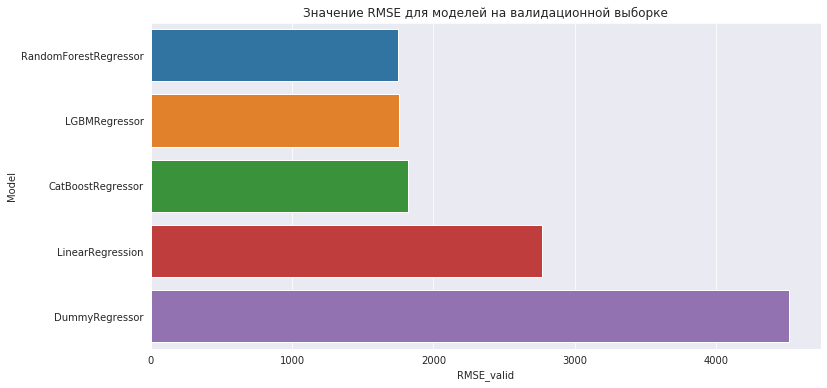

In [83]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')

sns.barplot(y=sort['Model'], x=sort['RMSE_valid'])

plt.title('Значение RMSE для моделей на валидационной выборке')
plt.show()

### Вывод:
1. построили 4 разные модели
2. постарались немного улучшить модели подбором гиперпараметров
3. Линейная регрессия показала результат метрики сильно хуже остальных моделей. Остальные модели имеют приблизительно одинаковые значения, Случаный лес имеет наилучший результат
4. все модели адекватны, так как константная модель сильно хуже выполнила предсказания


## Анализ моделей

Так как лучшие показатели метрики RMSE показали модели без кросс-валидации, объединим обучающую и валидационную выборки для более обширного обучения модели

In [84]:
df_features = pd.concat([features_train] + [features_valid])
df_target = pd.concat([target_train] + [target_valid])

display(df_features.shape)
df_target.shape

(271596, 9)

(271596,)

In [85]:
df_features_ordinal = pd.concat([features_train_ordinal] + [features_valid_ordinal])
df_target_ordinal = pd.concat([target_train_ordinal] + [target_valid_ordinal])

display(df_features_ordinal.shape)
df_target_ordinal.shape

(271596, 9)

(271596,)

In [86]:
df_features_ohe = pd.concat([features_train_ohe] + [features_valid_ohe])
df_target_ohe = pd.concat([target_train_ohe] + [target_valid_ohe])

display(df_features_ohe.shape)
df_target_ohe.shape

(271596, 311)

(271596,)

# Вычисляем значение метрики на тестовой выборке и время выполнения обучения и предсказания модели

### Случайный лес

__OHE__

In [87]:
%%time
best_model_forest.fit(df_features_ohe, df_target_ohe)

CPU times: user 2min 11s, sys: 0 ns, total: 2min 11s
Wall time: 2min 13s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [88]:
start = time.time()
best_model_forest.fit(df_features_ohe, df_target_ohe)
end = time.time()
time_fit_forest_ohe = end-start # in seconds
time_fit_forest_ohe

135.29417634010315

In [89]:
%%time
prediction_test_ohe = best_model_forest.predict(features_test_ohe)

CPU times: user 877 ms, sys: 0 ns, total: 877 ms
Wall time: 883 ms


In [90]:
start = time.time()
prediction_test_ohe = best_model_forest.predict(features_test_ohe)
end = time.time()
time_predict_forest_ohe = end-start # in seconds
time_predict_forest_ohe

0.922199010848999

__Ordinal__

In [91]:
start = time.time()
best_model_forest.fit(df_features_ordinal, df_target_ordinal)
end = time.time()
time_fit_forest = end-start # in seconds
time_fit_forest

13.836913347244263

In [92]:
start = time.time()
prediction_test = best_model_forest.predict(features_test_ordinal)
end = time.time()
time_predict_forest = end-start # in seconds
time_predict_forest

0.5749862194061279

In [93]:
score_forest_test_ohe = np.sqrt(mean_squared_error(target_test_ohe, prediction_test_ohe))
print('RandomForestRegressor (OHE): RMSE = {:.2f}'.format(score_forest_test_ohe))

RandomForestRegressor (OHE): RMSE = 1731.65


In [94]:
score_forest_test = np.sqrt(mean_squared_error(target_test_ordinal, prediction_test))
print('RandomForestRegressor: RMSE = {:.2f}'.format(score_forest_test))

RandomForestRegressor: RMSE = 1748.35


In [95]:
importances = best_model_forest.feature_importances_

feature_list = list(df_features.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

In [96]:
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
feature_results

,feature,importance
0,RegistrationYear,0.53
1,Power,0.26
2,Brand,0.04
3,Model,0.04
4,VehicleType,0.04
5,Kilometer,0.04
6,NotRepaired,0.02
7,FuelType,0.01
8,Gearbox,0.01


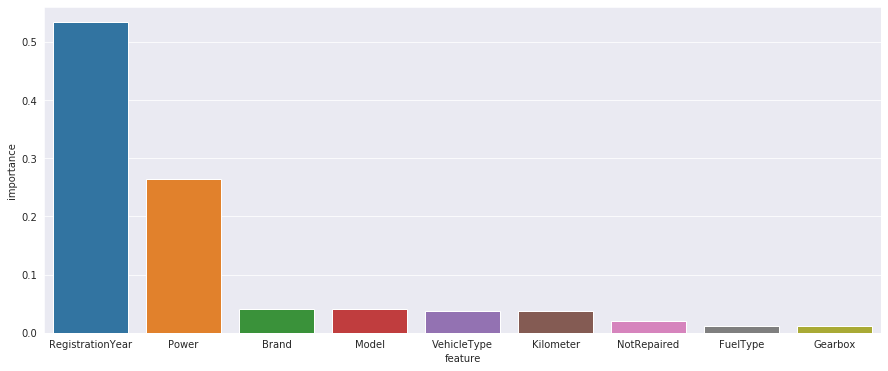

In [97]:
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')

sns.barplot(x='feature', y='importance', data=feature_results)#, sort=False)

plt.show()

### Линейная регрессия

__OHE__

In [98]:
%%time
model_LNR.fit(df_features_ohe, df_target_ohe)

CPU times: user 18.3 s, sys: 4.1 s, total: 22.4 s
Wall time: 22.4 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
start = time.time()
model_LNR.fit(df_features_ohe, df_target_ohe)
end = time.time()
time_fit_LNR_ohe = end-start # in seconds
time_fit_LNR_ohe

21.60268259048462

In [100]:
%%time
prediction_test = model_LNR.predict(features_test_ohe)

CPU times: user 83.7 ms, sys: 117 ms, total: 201 ms
Wall time: 198 ms


In [101]:
start = time.time()
prediction_test_ohe = model_LNR.predict(features_test_ohe)
end = time.time()
time_predict_LNR_ohe = end-start # in seconds
time_predict_LNR_ohe

0.2054896354675293

__Ordinal__

In [102]:
start = time.time()
model_LNR.fit(df_features_ordinal, df_target_ordinal)
end = time.time()
time_fit_LNR = end-start # in seconds
time_fit_LNR

0.1365823745727539

In [103]:
start = time.time()
prediction_test = model_LNR.predict(features_test_ordinal)
end = time.time()
time_predict_LNR = end-start # in seconds
time_predict_LNR

0.0031113624572753906

In [104]:
score_LNR_test_ohe = np.sqrt(mean_squared_error(target_test_ohe, prediction_test_ohe))
print('LinearRegression (OHE): RMSE = {:.2f}'.format(score_LNR_test_ohe))

LinearRegression (OHE): RMSE = 2807.61


In [105]:
score_LNR_test = np.sqrt(mean_squared_error(target_test_ordinal, prediction_test))
print('LinearRegression: RMSE = {:.2f}'.format(score_LNR_test))

LinearRegression: RMSE = 3159.60


In [106]:
importances = model_LNR.coef_

feature_list = list(df_features.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

In [107]:
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
feature_results

,feature,importance
0,RegistrationYear,154.55
1,Power,27.13
2,Model,0.76
3,Kilometer,-0.04
4,Brand,-3.28
5,VehicleType,-159.49
6,FuelType,-464.06
7,Gearbox,-498.20
8,NotRepaired,-875.08


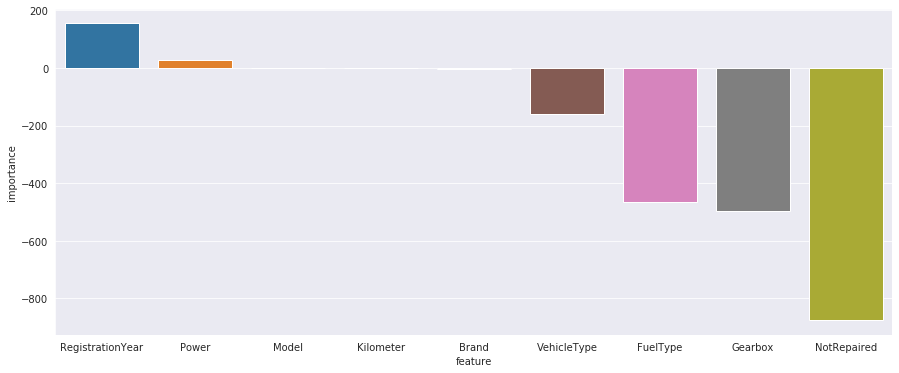

In [108]:
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')

sns.barplot(x='feature', y='importance', data=feature_results)#, sort=False)

plt.show()

### CatBoostRegressor

In [109]:
%%time
best_model_CDR.fit(df_features, df_target, cat_features=categorical)

0:	learn: 4445.4365607	total: 1.16s	remaining: 3m 50s
100:	learn: 1912.9650305	total: 1m 49s	remaining: 1m 47s
199:	learn: 1786.1386753	total: 3m 42s	remaining: 0us
CPU times: user 3min 29s, sys: 13.1 s, total: 3min 42s
Wall time: 3min 45s


In [110]:
start = time.time()
best_model_CDR.fit(df_features, df_target, cat_features=categorical)
end = time.time()
time_fit_CBR = end-start # in seconds
time_fit_CBR

0:	learn: 4445.4365607	total: 1.11s	remaining: 3m 41s
100:	learn: 1912.9650305	total: 1m 50s	remaining: 1m 48s
199:	learn: 1786.1386753	total: 3m 43s	remaining: 0us


225.33904910087585

In [111]:
%%time
prediction_test = best_model_CDR.predict(features_test)

CPU times: user 314 ms, sys: 7.56 ms, total: 322 ms
Wall time: 302 ms


In [112]:
start = time.time()
prediction_test = best_model_CDR.predict(features_test)
end = time.time()
time_predict_CBR = end-start # in seconds
time_predict_CBR

0.3852517604827881

In [113]:
score_CBR_test = np.sqrt(mean_squared_error(target_test_ohe, prediction_test))
print('CatBoostRegressor: RMSE = {:.2f}'.format(score_CBR_test))

CatBoostRegressor: RMSE = 1824.19


In [114]:
importances = best_model_CDR.feature_importances_

feature_list = list(df_features.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

In [115]:
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
feature_results

,feature,importance
0,RegistrationYear,34.19
1,Power,20.63
2,VehicleType,13.47
3,Brand,11.06
4,Kilometer,9.23
5,Model,4.00
6,NotRepaired,3.87
7,FuelType,2.36
8,Gearbox,1.18


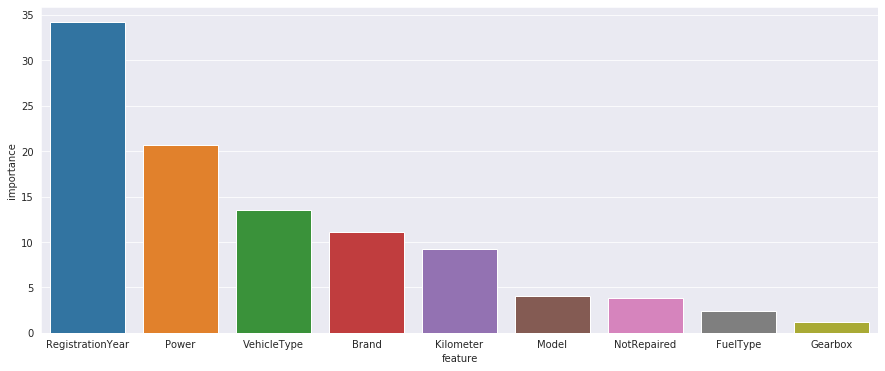

In [116]:
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')

sns.barplot(x='feature', y='importance', data=feature_results)#, sort=False)

plt.show()

### LGBMRegressor

__OHE__

In [117]:
%%time
best_model_LGBMR.fit(df_features_ohe, df_target_ohe)

CPU times: user 14.5 s, sys: 337 ms, total: 14.8 s
Wall time: 15 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [118]:
start = time.time()
best_model_LGBMR.fit(df_features_ohe, df_target_ohe)
end = time.time()
time_fit_LGBMR_ohe = end-start # in seconds
time_fit_LGBMR_ohe

15.894765138626099

In [119]:
%%time
prediction_test = best_model_LGBMR.predict(features_test_ohe)

CPU times: user 1.07 s, sys: 62.9 ms, total: 1.13 s
Wall time: 1.19 s


In [120]:
start = time.time()
prediction_test_ohe = best_model_LGBMR.predict(features_test_ohe)
end = time.time()
time_predict_LGBMR_ohe = end-start # in seconds
time_predict_LGBMR_ohe

1.1032838821411133

__Ordinal__

In [121]:
start = time.time()
best_model_LGBMR.fit(df_features_ordinal, df_target_ordinal)
end = time.time()
time_fit_LGBMR = end-start # in seconds
time_fit_LGBMR

13.388784170150757

In [122]:
start = time.time()
prediction_test = best_model_LGBMR.predict(features_test_ordinal)
end = time.time()
time_predict_LGBMR = end-start # in seconds
time_predict_LGBMR

0.9045872688293457

In [123]:
score_LGBMR_test_ohe = np.sqrt(mean_squared_error(target_test_ohe, prediction_test_ohe))
print('LGBMRegressor (OHE): RMSE = {:.2f}'.format(score_LGBMR_test_ohe))

LGBMRegressor (OHE): RMSE = 1763.14


In [124]:
score_LGBMR_test = np.sqrt(mean_squared_error(target_test_ordinal, prediction_test))
print('LGBMRegressor: RMSE = {:.2f}'.format(score_LGBMR_test))

LGBMRegressor: RMSE = 1758.44


In [125]:
importances = best_model_LGBMR.feature_importances_

feature_list = list(df_features.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

In [126]:
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
feature_results

,feature,importance
0,RegistrationYear,1344
1,Power,1295
2,Model,883
3,Brand,875
4,VehicleType,560
5,Kilometer,524
6,FuelType,218
7,NotRepaired,165
8,Gearbox,136


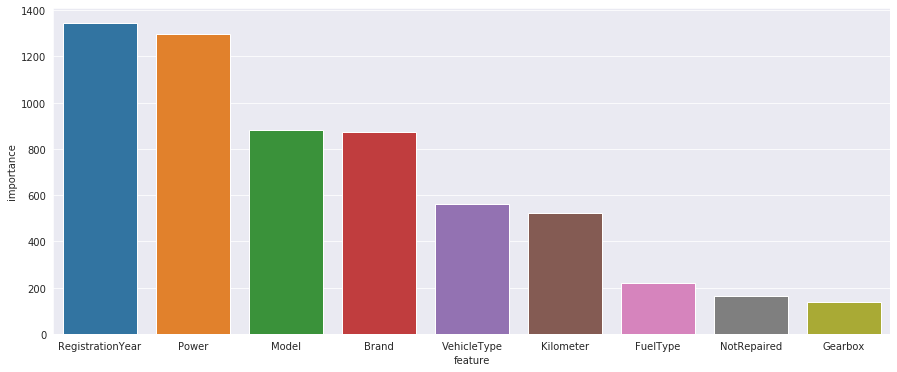

In [127]:
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')

sns.barplot(x='feature', y='importance', data=feature_results)#, sort=False)

plt.show()

### DummyRegressor

In [128]:
model=DummyRegressor(strategy='mean')

model.fit(df_features_ordinal, df_target_ordinal)
prediction_valid = model.predict(features_test_ordinal)

score_dummy_test = np.sqrt(mean_squared_error(target_test_ordinal, prediction_valid))

print('Модель DummyRegressor: RMSE = {:.2f}'.format(score_dummy_test))

Модель DummyRegressor: RMSE = 4564.33


### Итоги

In [129]:
values_models['RMSE_test'] = [score_forest_test, score_LNR_test, score_CBR_test, score_LGBMR_test,score_dummy_test]
values_models['time_fit_(s)'] = [time_fit_forest, time_fit_LNR, time_fit_CBR, time_fit_LGBMR,0]
values_models['time_predict_(s)'] = [time_predict_forest, time_predict_LNR, time_predict_CBR, time_predict_LGBMR,0]

In [130]:
values_models

,Model,RMSE_valid,RMSE_test,time_fit_(s),time_predict_(s)
0,RandomForestRegressor,"1,750.82","1,748.35",13.84,0.57
1,LinearRegression,"2,769.52","3,159.60",0.14,0.00
2,CatBoostRegressor,"1,819.80","1,824.19",225.34,0.39
3,LGBMRegressor,"1,754.57","1,758.44",13.39,0.90
4,DummyRegressor,"4,514.40","4,564.33",0.00,0.00


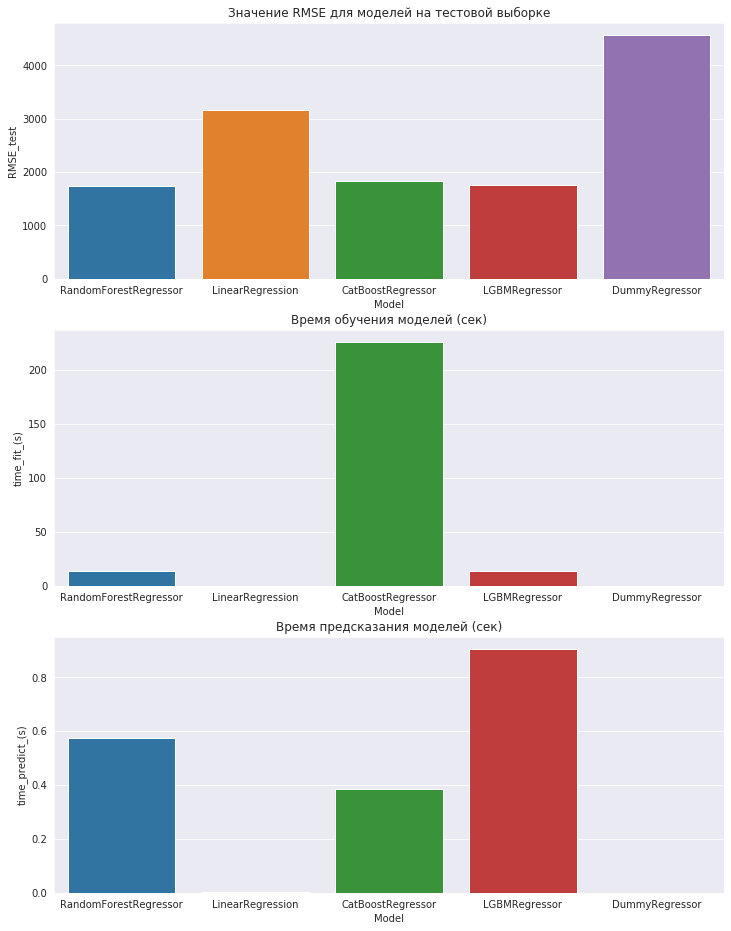

In [131]:
plt.figure(figsize=(12,16))
sns.set_style('darkgrid')

plt.subplot(311)
plt.title('Значение RMSE для моделей на тестовой выборке')
sns.barplot(x=values_models['Model'], y=values_models['RMSE_test'])

plt.subplot(312)
plt.title('Время обучения моделей (сек)')
sns.barplot(x=values_models['Model'], y=values_models['time_fit_(s)'])

plt.subplot(313)
plt.title('Время предсказания моделей (сек)')
sns.barplot(x=values_models['Model'], y=values_models['time_predict_(s)'])

plt.tight_layout
plt.show()

In [132]:
time_encoding = pd.DataFrame([
    ['RandomForestRegressor', time_fit_forest, time_fit_forest_ohe, time_predict_forest, time_predict_forest_ohe],
    ['LinearRegression', time_fit_LNR, time_fit_LNR_ohe, time_predict_LNR, time_predict_LNR_ohe],
#     ['CatBoostRegressor', time_fit_CBR, time_fit_CBR_ohe, time_predict_CBR, time_predict_CBR_ohe],
    ['LGBMRegressor', time_fit_LGBMR, time_fit_LGBMR_ohe, time_predict_LGBMR, time_predict_LGBMR_ohe]
],
    columns=['Model', 'time_fit_(ordinal)', 'time_fit_(ohe)', 'time_predict_(ordinal)', 'time_predict_(ohe)']
)
time_encoding

,Model,time_fit_(ordinal),time_fit_(ohe),time_predict_(ordinal),time_predict_(ohe)
0,RandomForestRegressor,13.84,135.29,0.57,0.92
1,LinearRegression,0.14,21.60,0.00,0.21
2,LGBMRegressor,13.39,15.89,0.90,1.10


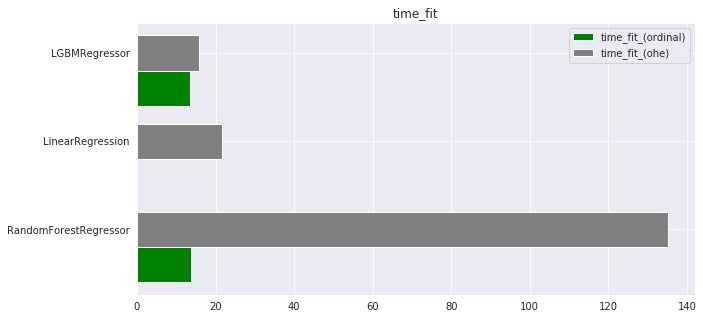

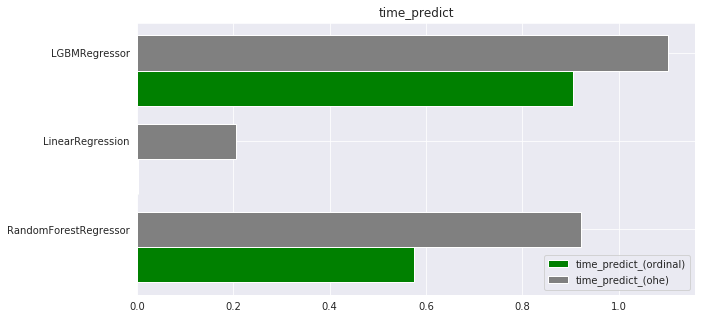

In [143]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.subplots(1,2,1)
ind = np.arange(len(time_encoding))
width = 0.4

ax.barh(ind, time_encoding['time_fit_(ordinal)'],width, color='green', label='time_fit_(ordinal)')
ax.barh(ind + width, time_encoding['time_fit_(ohe)'], width, color='grey', label='time_fit_(ohe)')
ax.set(yticks=ind + width, yticklabels=time_encoding['Model'])
ax.legend()
plt.title('time_fit')

plt.show()

fig, ax2 = plt.subplots(figsize=(10,5))
ax2.barh(ind, time_encoding['time_predict_(ordinal)'],width,  color='green', label='time_predict_(ordinal)')
ax2.barh(ind + width, time_encoding['time_predict_(ohe)'], width, color='grey', label='time_predict_(ohe)')

ax2.set(yticks=ind + width, yticklabels=time_encoding['Model'])
ax2.legend()
plt.title('time_predict')

plt.show()

## Общий вывод:

1. получили таблицу с целью построения модели предсказания рыночной стоимости автомобилей (целевой признак) на основании признаков, содержащихся в таблице
2. провели предподготовку данных: заменили пропуски, удалили столбцы, не влияющие на целевой признак, избавились от аномальных и нереальных значений, проверили корреляцию признаков
3. обучили 4 модели (метрика RMSE) и выполнили предсказания на валидационной выборке: RandomForestRegressor, LinearRegression, CatBoostRegressor, LGBMRegressor. Наилучший результат у RandomForestRegressor, наихудший - LinearRegression
4. проверили модели на адекватность: значение метрики RMSE у константной модели значительно хуже
5. выполнили предсказания на тестовой выборке и замерили время обучения моделей и время предсказания моделями:
- RandomForestRegressor показал наилучшие значения предсказания, однако время обучения и предсказания модели довольно длительные;
- LinearRegression обучается и предсказывает очень быстро, но качество предсказаний сильно ниже остальных моделей;
- CatBoostRegressor обучается сильно дольше всех, но быстро предсказывает, качество предсказаний немного хуже LGBMRegressor;
- LGBMRegressor на втором месте по качеству предсказаний и первая по времени обучения модели, но на последнем месте по времени предсказания.  

Золотой серединой выглядит модель LGBMRegressor, довольно хорошее качество предсказаний, очень быстрое обучение (всего несколько секунд) и, учитывая, что предсказания выполняются всего лишь на несколько милисекунд медленнее остальных моделей, относительно недолгое время предсказаний.  
Однако необходимо учесть количество предсказаний в промежутке времени, так как модель обучится однажды, а предсказывать будет часто и много раз, возможно, разница в несколько милисекунд на крупном отрезке даст сильную задержку.

